### Cleaning the Total Losses dataframe
**Dataset:** [Total economic losses per country and event type (1980-2023)](https://climate-adapt.eea.europa.eu/en/knowledge/economic-losses/economic-losses-and-fatalities?activeTab=31d4b1fa-94dc-47ee-81bd-5b80fb3909f9)

**Steps Taken:**
1. Import pandas and read in the dataset
2. Basic cleaning
3. Rename columns for clarity
4. Drop unused columns
5. Removes rows containing 'tooltip'

In [17]:
import pandas as pd

totaldf = pd.read_csv('tab_type.csv', encoding="utf-16", sep="\t", header=1)

totaldf = totaldf.drop_duplicates()  # Remove duplicate rows
totaldf.columns = totaldf.columns.str.strip()  # Strip whitespace
totaldf = totaldf.reset_index(drop=True)

totaldf = totaldf.rename(columns={
    'Unnamed: 0': 'Country',
    'Unnamed: 1': 'Country 2',
    'Unnamed: 2': 'Data Source',
    'Unnamed: 3': 'Hazard Type',
    'Unnamed: 4': 'Hazard Subtype',
    'Unnamed: 5': 'Losses Currency',
    'Unnamed: 6': 'Field Values',
})
#drop column Country 2 and Field Values, data source, hazard type
totaldf = totaldf.drop(columns=['Country 2'])
totaldf = totaldf.drop(columns=['Data Source'])
totaldf = totaldf.drop(columns=['Hazard Type'])
totaldf = totaldf[~totaldf["Field Values"].astype(str).str.contains("tooltip", case=False, na=False)]

totaldf.head(5)


,Country,Hazard Subtype,Losses Currency,Field Values,Hydrological,Meteorological,Climatological (heatwaves),Climatological (Other)
0,Albania (AL),Climatological (heatwaves),M€,Field Values,NaN,NaN,0,NaN
3,Albania (AL),Climatological (Other),M€,Field Values,NaN,NaN,NaN,76
6,Albania (AL),Hydrological,M€,Field Values,343,NaN,NaN,NaN
9,Albania (AL),Meteorological,M€,Field Values,NaN,10,NaN,NaN
12,Austria (AT),Climatological (heatwaves),M€,Field Values,NaN,NaN,1 673,NaN


### Cleaning the Insured Losses dataframe
**Dataset:** [Total insured losses per country and event type (1980-2023)](https://climate-adapt.eea.europa.eu/en/knowledge/economic-losses/economic-losses-and-fatalities?activeTab=31d4b1fa-94dc-47ee-81bd-5b80fb3909f9)

**Steps Taken:**
1. Basic cleaning
2. Rename columns for clarity
3. Drop unused columns
4. Removes rows containing 'tooltip'

In [18]:
insureddf = pd.read_csv('insuredlosses.csv', encoding="utf-16", sep="\t", header=1)

# Basic cleaning

insureddf = insureddf.drop_duplicates()  # Remove duplicate rows
insureddf.columns = insureddf.columns.str.strip()  # Strip whitespace
insureddf = insureddf.reset_index(drop=True)

#rename columns
insureddf = insureddf.rename(columns={
    'Unnamed: 0': 'Country',
    'Unnamed: 1': 'Country 2',
    'Unnamed: 2': 'Data Source',
    'Unnamed: 3': 'Hazard Type',
    'Unnamed: 4': 'Hazard Subtype',
    'Unnamed: 5': 'Losses Currency',
    'Unnamed: 6': 'Field Values',
})

#drop column Country 2 and Field Values, data source, hazard type
insureddf = insureddf.drop(columns=['Country 2'])
insureddf = insureddf.drop(columns=['Data Source'])
insureddf = insureddf.drop(columns=['Hazard Type'])
insureddf = insureddf[~insureddf["Field Values"].astype(str).str.contains("tooltip", case=False, na=False)]

# Preview
insureddf.head(5)


,Country,Hazard Subtype,Losses Currency,Field Values,Hydrological,Meteorological,Climatological (heatwaves),Climatological (Other)
0,Albania (AL),Climatological (heatwaves),M€,Field Values,NaN,NaN,0,NaN
3,Albania (AL),Climatological (Other),M€,Field Values,NaN,NaN,NaN,0
6,Albania (AL),Hydrological,M€,Field Values,0,NaN,NaN,NaN
9,Albania (AL),Meteorological,M€,Field Values,NaN,0,NaN,NaN
12,Austria (AT),Climatological (heatwaves),M€,Field Values,NaN,NaN,14,NaN


# Cleaning before merging

In [ ]:
import re
import pandas as pd

def tidy_losses(df, value_name):
    df = df.copy()

    # Normalize names and strings
    df.columns = [c.strip() for c in df.columns]
    for c in ['Country']:
        if c in df.columns:
            df[c] = df[c].astype(str).str.strip()

    # Select hazard columns explicitly
    hazard_cols = [c for c in df.columns if c in [
        'Hydrological',
        'Meteorological',
        'Climatological (heatwaves)',
        'Climatological (Other)'
    ]]

    # Melt: only keep Country 
    tidy = df.melt(
        id_vars=[c for c in ['Country'] if c in df.columns],
        value_vars=hazard_cols,
        var_name='Hazard',
        value_name=value_name
    )

    # Clean numbers
    tidy[value_name] = (
        tidy[value_name].astype(str)
        .str.replace(',', '', regex=False)
        .str.replace('\u00a0', '', regex=False)  # NBSP
        .str.replace(' ', '', regex=False)      # space as thousands sep
        .apply(lambda x: re.sub(r'[^0-9.\-]', '', x))
        .replace({'': None, '.': None, '-': None})
        .astype(float)
    )

    # Drop rows with no values
    tidy = tidy[tidy[value_name].notna()]

    # Sort
    tidy = tidy.sort_values(['Country','Hazard']).reset_index(drop=True)
    return tidy

from IPython.display import display

insured_tidy = tidy_losses(insureddf, 'Insured Loss in MEUR')
display(insured_tidy.head(10))

total_tidy = tidy_losses(totaldf, 'Total Loss in MEUR')

display(total_tidy.head(10))

,Country,Hazard,Insured Loss in MEUR
0,Albania (AL),Climatological (Other),0.0
1,Albania (AL),Climatological (heatwaves),0.0
2,Albania (AL),Hydrological,0.0
3,Albania (AL),Meteorological,0.0
4,Austria (AT),Climatological (Other),624.0
5,Austria (AT),Climatological (heatwaves),14.0
6,Austria (AT),Hydrological,1049.0
7,Austria (AT),Meteorological,1100.0
8,Belgium (BE),Climatological (Other),0.0
9,Belgium (BE),Climatological (heatwaves),0.0


,Country,Hazard,Total Loss in MEUR
0,Albania (AL),Climatological (Other),76.0
1,Albania (AL),Climatological (heatwaves),0.0
2,Albania (AL),Hydrological,343.0
3,Albania (AL),Meteorological,10.0
4,Austria (AT),Climatological (Other),1472.0
5,Austria (AT),Climatological (heatwaves),1673.0
6,Austria (AT),Hydrological,7519.0
7,Austria (AT),Meteorological,4062.0
8,Belgium (BE),Climatological (Other),0.0
9,Belgium (BE),Climatological (heatwaves),280.0


In [ ]:
# Merge Total and Insured tidy df
merged = pd.merge(
    total_tidy,
    insured_tidy,
    on=['Country','Hazard'],  
    how='outer'
).fillna(0)
# Calculate protection gap
merged['Gap in MEUR'] = merged['Total Loss in MEUR'] - merged['Insured Loss in MEUR']
nz = merged['Total Loss in MEUR'] > 0
merged['Gap (%)'] = None
merged.loc[nz, 'Gap (%)'] = 1 - (merged.loc[nz, 'Insured Loss in MEUR'] / merged.loc[nz, 'Total Loss in MEUR'])
merged['Gap (%)'] = merged['Gap (%)'].clip(0, 1)
# Only valid hazards
valid_haz = {
    'Hydrological',
    'Meteorological',
    'Climatological (heatwaves)',
    'Climatological (Other)'
}
merged = merged[merged['Hazard'].isin(valid_haz)]
# Keep only real countries (names with "(XX)")
merged = merged[merged['Country'].astype(str).str.match(r'.+\([A-Z]{2}\)$')]

# Remove rows with both Total and Insured = 0
merged = merged[~((merged['Total Loss in MEUR'] == 0) & (merged['Insured Loss in MEUR'] == 0))]

# Deduplicate and tidy strings
merged = (merged
          .drop_duplicates(subset=['Country','Hazard','Total Loss in MEUR','Insured Loss in MEUR'])
          .assign(Country=lambda d: d['Country'].str.strip(),
                  Hazard=lambda d: d['Hazard'].str.strip())
          .sort_values(['Country','Hazard'])
          .reset_index(drop=True))

# Reorder columns
cols = ['Country','Hazard','Total Loss in MEUR','Insured Loss in MEUR',
        'Gap in MEUR','Gap (%)']
merged = merged[cols]

# Show preview
merged.head(20)


,Country,Hazard,Total Loss in MEUR,Insured Loss in MEUR,Gap in MEUR,Gap (%)
0,Albania (AL),Climatological (Other),76.0,0.0,76.0,1.0
1,Albania (AL),Hydrological,343.0,0.0,343.0,1.0
2,Albania (AL),Meteorological,10.0,0.0,10.0,1.0
3,Austria (AT),Climatological (Other),1472.0,624.0,848.0,0.576087
4,Austria (AT),Climatological (heatwaves),1673.0,14.0,1659.0,0.991632
5,Austria (AT),Hydrological,7519.0,1049.0,6470.0,0.860487
6,Austria (AT),Meteorological,4062.0,1100.0,2962.0,0.729197
7,Belgium (BE),Climatological (heatwaves),280.0,0.0,280.0,1.0
8,Belgium (BE),Hydrological,11396.0,2825.0,8571.0,0.752106
9,Belgium (BE),Meteorological,5312.0,3855.0,1457.0,0.274285


## creating csv for power bi

In [32]:
# Export to CSV for Power BI
# DO NOT TOUCH
merged.to_csv("Climate_Losses_Cleaned.csv", index=False, encoding="utf-8-sig")
merged.to_csv("./data/Climate_Losses_Cleaned.csv", index=False, encoding="utf-8-sig")


OSError: Cannot save file into a non-existent directory: 'data'

In [35]:
import plotly.express as px

fig = px.choropleth(
    merged,
    locations="Country",
    locationmode="country names",   # if 'Austria (AT)' you'll need to strip codes
    color="Gap (%)",
    hover_name="Country",
    hover_data=["Total Loss in MEUR","Insured Loss in MEUR","Gap in MEUR"],
    color_continuous_scale="Reds",
    title="Climate Loss Protection Gap in Europe"
)
    # Focus on Europe
fig.update_geos(
    projection_type="mercator",
    center={"lat": 55, "lon": 15},  # center roughly over Europe
    lataxis_range=[45, 80],         # vertical zoom
    lonaxis_range=[-35, 75]         # horizontal zoom
)
fig.show()


### Regression Analysis: Can we Predict the Protection Gap?

We used a simple **linear regression model** to see whether a country’s protection gap (%) can be predicted from:

- **Total Loss in MEUR**  
- **Insured Loss in MEUR**  
- **Hazard Type** (encoded as categorical variables)  

The idea:  
- If the model has good predictive power, it means **loss values and hazard types explain the variation in insurance coverage**.  
- If the model performs poorly, it suggests the protection gap is largely systemic (e.g. most countries have near-100% gaps regardless of hazard).

**R² Score:**  
- The `R²` value printed shows how much of the variation in `Gap (%)` is explained by the model.  
- An `R²` close to 0 means the model cannot improve much beyond simply guessing the average gap.  
- This would confirm our observation: **many countries have gaps at or near 100%**, making them hard to differentiate with regression.  

 Takeaway: Regression tells us that underinsurance is a **broad, structural problem** across Europe rather than something explained by hazard type or recent losses alone.


In [36]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

df = pd.read_csv("Climate_Losses_Cleaned.csv")

# Features + Target
X = df[["Total Loss in MEUR","Insured Loss in MEUR","Hazard"]]
y = df["Gap (%)"]

# One-hot encode Hazard
preprocessor = ColumnTransformer(
    transformers=[("hazard", OneHotEncoder(drop="first"), ["Hazard"])],
    remainder="passthrough"
)

# Simple regression
model = Pipeline([
    ("prep", preprocessor),
    ("reg", LinearRegression())
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)

print("R^2:", model.score(X_test, y_test))


R^2: -2.1542558772963947


### Regression Results: Predicted vs Actual Gap (%)

This plot compares the **predicted protection gap** from our regression model with the **actual gap values**:

- Each blue dot = one test observation (country–hazard combination).  
- The red dashed line = perfect predictions (where predicted = actual).  

**What we see:**
- Most points cluster tightly near the **top-right corner** (Gap ~ 0.8–1.0).  
- The model is unable to spread predictions across the full range of possible gaps.  
- This reflects the underlying data problem: **many countries have protection gaps close to 100%**, regardless of hazard type or loss values.  

**Interpretation:**
- Regression confirms our earlier suspicion: **the gap is largely structural**, not easily explained by hazard or recent loss history.  
- This makes regression less useful for *prediction*, but valuable for showing that the insurance shortfall is systemic across Europe.  

 This motivates trying **clustering instead of regression**, to group countries by their overall risk/insurance profile rather than trying to predict a single number.


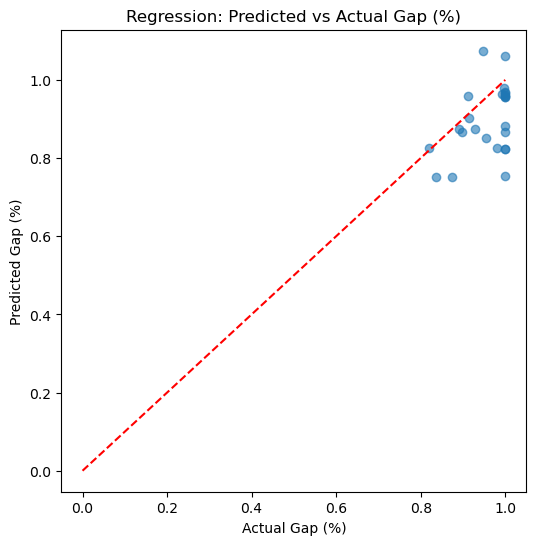

In [38]:
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([0,1],[0,1], 'r--')  # perfect prediction line
plt.xlabel("Actual Gap (%)")
plt.ylabel("Predicted Gap (%)")
plt.title("Regression: Predicted vs Actual Gap (%)")
plt.show()


In [ ]:
pip install adjustText


Note: you may need to restart the kernel to use updated packages.


# K Means Clustering
#Good

### Clustering Results: Country Profiles of Climate Loss & Protection Gap

Since regression showed that protection gaps are **structural** rather than easily predicted,  
we applied **K-Means clustering** to group countries based on their:

- **Total Loss (MEUR)**  
- **Gap in MEUR (uninsured losses)**  
- **Gap (%)**  

**Why log scale?**  
- Climate losses vary from **tens of millions** (e.g. Albania) to **hundreds of billions** (e.g. Germany).  
- On a normal (linear) chart, small countries would be squashed into the corner while outliers dominate the plot.  
- A **log scale compresses large values and expands small ones**, letting us see *both small and large countries together* on the same chart.  
- This way, the **overall distribution and relative clusters** become clear.  


**Plot explanation:**
- Each dot = one country.  
- Axes are log-scaled so that both small countries (tens of millions) and large ones (hundreds of billions) fit on the same chart.  
- Colours = cluster membership, showing countries with similar loss–gap profiles.  

**What we see:**
- A cluster of **smaller economies** with relatively low losses but still very high protection gaps.  
- A middle cluster of **medium-sized countries** with larger absolute losses but still gaps in the thousands of MEUR.  
- A distinct group of **outliers** — Germany, France, Italy, Spain — with extremely high total losses and uninsured gaps, standing apart from the rest of Europe.  

**Interpretation:**
- Clustering reveals **risk tiers**: small countries, mid-tier, and major economies.  
- This is more informative than regression, because it highlights where systemic underinsurance is most **financially threatening**.  
- From a financial stability view, the biggest concern lies in the **large-economy outliers** — their protection gaps translate into systemic risk for insurers and governments.  


c:\ProgramData\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning:

Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.

  File "c:\ProgramData\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\ProgramData\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable

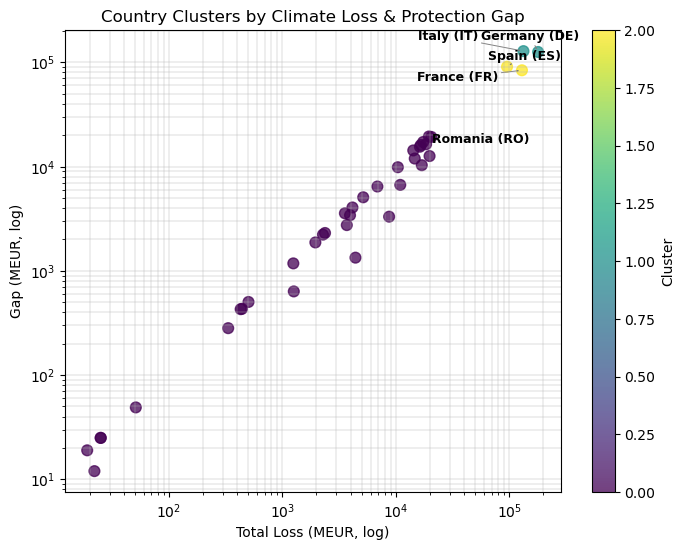

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from adjustText import adjust_text

# Aggregate losses by country
agg = merged.groupby("Country").agg({
    "Total Loss in MEUR": "sum",
    "Insured Loss in MEUR": "sum",
    "Gap in MEUR": "sum"
}).reset_index()

# Recalculate Gap % at country level
agg["Gap (%)"] = agg["Gap in MEUR"] / agg["Total Loss in MEUR"]

# filter out countries with 0 values to avoid log(0)
agg = agg[(agg["Total Loss in MEUR"] > 0) & (agg["Gap in MEUR"] > 0)]

# KMeans clustering
X = agg[["Total Loss in MEUR","Gap in MEUR"]]
kmeans = KMeans(n_clusters=3, random_state=42).fit(X)
agg["Cluster"] = kmeans.labels_

# Scatter plot
plt.figure(figsize=(8,6))
sc = plt.scatter(agg["Total Loss in MEUR"], agg["Gap in MEUR"],
                 c=agg["Cluster"], s=60, alpha=0.75)

plt.xscale('log'); plt.yscale('log')
plt.xlabel("Total Loss (MEUR, log)")
plt.ylabel("Gap (MEUR, log)")
plt.title("Country Clusters by Climate Loss & Protection Gap")

cbar = plt.colorbar(sc)
cbar.set_label("Cluster")

plt.grid(True, which='both', linewidth=0.3)

# annotate top 5 by gap size
top = agg.nlargest(5, "Gap in MEUR")
texts = []
for _, r in top.iterrows():
    texts.append(
        plt.text(r["Total Loss in MEUR"], r["Gap in MEUR"], r["Country"],
                 fontsize=9, weight="bold")
    )

adjust_text(texts, arrowprops=dict(arrowstyle="->", color='gray', lw=0.7))
plt.show()

